In the original construct, there was an extra base accidentally added, causing the library to be out-of-frame. We'll look further into this and see how many sequences are affected and in what way.

In [63]:
import pandas as pd
from Bio.Seq import Seq
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

In [49]:
# read in re-scored reference file, which has column for exon sequence
splicemod_ref = pd.read_table('../ref/splicemod/splicemod_ref_rescored.txt', sep='\t', header=0,
                             dtype={'sub_id' : str, 'exon_seq': str})
print len(splicemod_ref)
# replace NaN with blank string
splicemod_ref.exon_seq = splicemod_ref.exon_seq.fillna('')
# focus on sequences with an exon sequence (i.e not controls)
splicemod_ref = splicemod_ref[splicemod_ref.exon_seq != '']
print len(splicemod_ref)

26754
26666


Add the extra base to the front and two extra to the end and translate the exonic sequence.

In [50]:
splicemod_ref['shifted_prot_seq'] = [str(Seq('C' + exon_seq + 'GG').translate()) if len(exon_seq) > 0 else ''
                                     for exon_seq in splicemod_ref.exon_seq]

Let's count the number of stop codons in each shifted sequence

In [51]:
# stop codons per sequence
splicemod_ref['num_stop_codons'] = [x.count('*') for x in splicemod_ref.shifted_prot_seq]
splicemod_ref.num_stop_codons.describe()

count    26666.000000
mean         1.612465
std          1.413858
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: num_stop_codons, dtype: float64

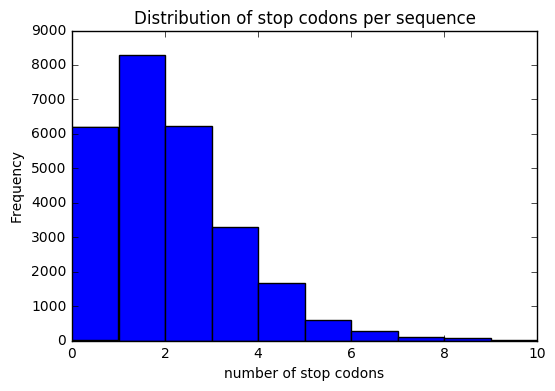

In [52]:
splicemod_ref['num_stop_codons'].plot.hist()
plt.title('Distribution of stop codons per sequence')
plt.xlabel('number of stop codons')
plt.show()

In [53]:
len(splicemod_ref[splicemod_ref.num_stop_codons == 0]) / float(len(splicemod_ref))

0.23205580139503487

23% of the library had no stop codon introduced, while the remaining 77% contain an introduced stop codon.

Let's read in the cleaned up data and add the stop codon information.

In [62]:
splicemod_ref[['id', 'shifted_prot_seq', 'num_stop_codons']].to_csv('../processed_data/splicemod/splicemod_stop_codon_info.txt',
                                                                    sep='\t', index=False)

In [121]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)

options(stringsAsFactors = F)

data <- read.table('../processed_data/splicemod/splicemod_data_clean.txt', sep='\t', header=T,
                    colClasses = c('sub_id' = 'character')) %>%
    left_join(read.table('../processed_data/splicemod/splicemod_stop_codon_info.txt', sep='\t', header=T), by='id')

In [122]:
%%R
data <- data %>%
    mutate(has_stop_codon = ifelse(num_stop_codons == 0, F, T),
          has_stop_codon = ifelse(is.na(num_stop_codons), NA, has_stop_codon))

Is there difference in replicability between sequences with/without introduced stop codons?

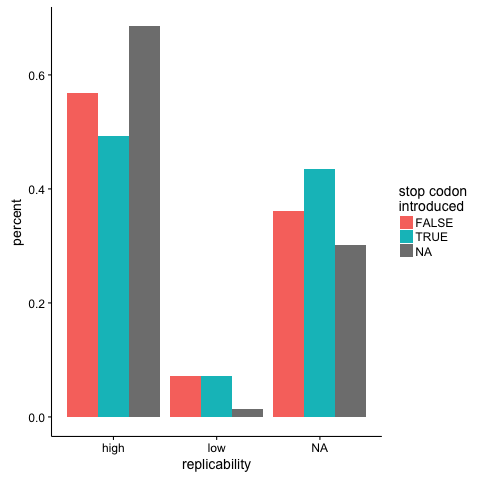

In [123]:
%%R
data %>%
    group_by(has_stop_codon) %>%
    count(rep_quality) %>%
    group_by(has_stop_codon) %>%
    mutate(pct = n / sum(n)) %>%
    ggplot(aes(rep_quality, pct)) + geom_bar(stat='identity', aes(fill = has_stop_codon), position='dodge') +
    labs(x = 'replicability', fill = 'stop codon\nintroduced', y = 'percent')

In [127]:
%%R
fisher.test(table(select(data, has_stop_codon, rep_quality)))


	Fisher's Exact Test for Count Data

data:  table(select(data, has_stop_codon, rep_quality))
p-value = 0.02188
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.021619 1.338038
sample estimates:
odds ratio 
  1.167961 



Small and barely significant difference in high/low replicability between sequences with/without introduced stop codon.

Is there a difference in total reads between sequences with/without stop codon?

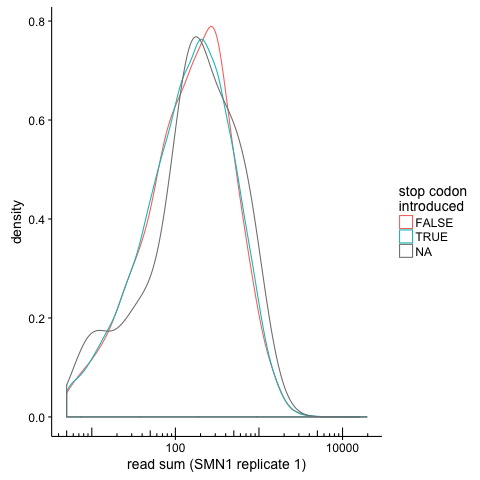

In [124]:
%%R
ggplot(data, aes(R1_sum_smn1)) + geom_density(aes(color = has_stop_codon)) +
    scale_x_log10() + annotation_logticks(sides = 'b') +
    labs(x = 'read sum (SMN1 replicate 1)', color = 'stop codon\nintroduced')

In [125]:
%%R
t.test(R1_sum_smn1 ~ has_stop_codon, data)


	Welch Two Sample t-test

data:  R1_sum_smn1 by has_stop_codon
t = -1.2233, df = 6854, p-value = 0.2212
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18.570791   4.298885
sample estimates:
mean in group FALSE  mean in group TRUE 
           260.2856            267.4215 



No significant difference in total read sum.

In [128]:
%%R
data <- data %>% filter(rep_quality == 'high')

Is there a difference in inclusion index?

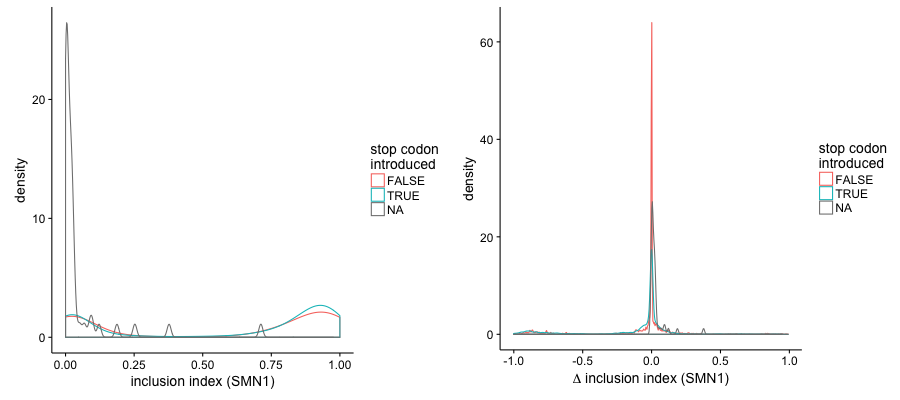

In [118]:
%%R -w 900 -h 400 -u px
gg1 <- ggplot(data, aes(index_smn1)) + geom_density(aes(color = has_stop_codon)) +
    labs(x = 'inclusion index (SMN1)', color = 'stop codon\nintroduced')
gg2 <- ggplot(data, aes(dpsi_smn1)) + geom_density(aes(color = has_stop_codon)) +
    labs(x = expression(paste(Delta, ' inclusion index (SMN1)')), color = 'stop codon\nintroduced')

plot_grid(gg1, gg2, nrow = 1)

In [119]:
%%R
t.test(index_smn1 ~ has_stop_codon, data)


	Welch Two Sample t-test

data:  index_smn1 by has_stop_codon
t = -3.8496, df = 4013, p-value = 0.0001201
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05699349 -0.01853026
sample estimates:
mean in group FALSE  mean in group TRUE 
          0.5513639           0.5891258 



In [120]:
%%R
t.test(dpsi_smn1 ~ has_stop_codon, data)


	Welch Two Sample t-test

data:  dpsi_smn1 by has_stop_codon
t = 8.9539, df = 4366.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04751648 0.07415776
sample estimates:
mean in group FALSE  mean in group TRUE 
        -0.06386402         -0.12470114 



Small but significant difference in inclusion index. Small but significant difference in delta inclusion index.

In [130]:
%%R
data <- data %>%
    mutate(strong_lof = ifelse(dpsi_smn1 <= -0.50, T, F),
           strong_lof = ifelse(is.na(dpsi_smn1), NA, strong_lof))

table(data$strong_lof)


FALSE  TRUE 
 8854  1428 


In [132]:
%%R
table(select(data, strong_lof, has_stop_codon))

          has_stop_codon
strong_lof FALSE TRUE
     FALSE  2163 6645
     TRUE    247 1181


In [131]:
%%R
fisher.test(table(select(data, strong_lof, has_stop_codon)))


	Fisher's Exact Test for Count Data

data:  table(select(data, strong_lof, has_stop_codon))
p-value = 8.585e-10
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.343884 1.807536
sample estimates:
odds ratio 
  1.556314 

